# Overview
This document aims to give an overview of the progress on the project of predicting vapour pressure using MDFPs with code and data

## Baseline
As a first step, an updated conda environment was created used to generate about a single 3D conformer for about 3000 molecules, which were  simulated in water for 5 nanoseconds. The molecules were previously curated by Dr. ShuZe Wang. All conformers are stored in the public database "conformers" and all relevant data is stored in schema cs_mdf_schema.

In [4]:
import sys
sys.path.append('../')
from carl.utils_carl import get_mdfps


In [2]:
from carl.utils_carl import *
df_mdfps = get_mdfps(which='one_5ns')

2980 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


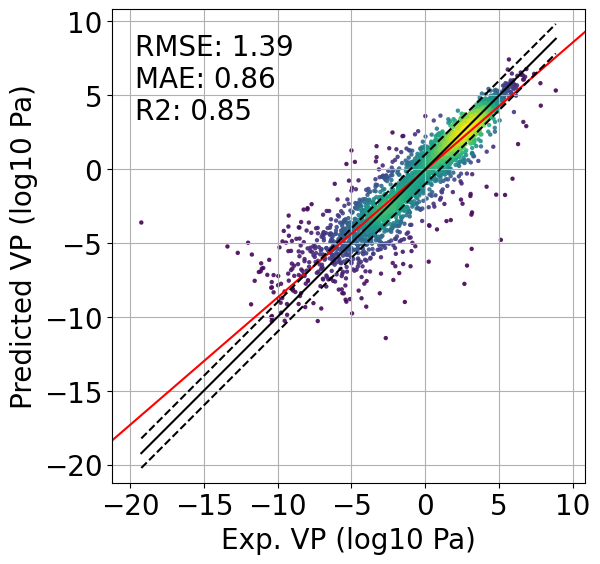

In [5]:
from utils_carl import train_pred_xgboost,density_plot,getStatValues,density_plot_multiple
from functools import reduce
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
real_one_to_one,prediction_one_to_one,molregnos,confids = train_pred_xgboost(df_mdfps,params,splits=5) #we do 5-fold cross-validation
density_plot(real_one_to_one,prediction_one_to_one,print_stats=False)

We get decent predictions, in line with results obtained by ShuZe

## Using multiple starting conformers

We perform a few tests assing:
1. The performance of model trained on one conformer on different conformers from the same molecule
2. Does data augmentation with multiple starting conformers per mol improve the performance

### Predictive ability towards new conformers

In [6]:
#train model on one conformer of all molecules
import xgboost as xgb
import numpy as np
train_x = np.array(df_mdfps['mdfp'].tolist())
train_y = np.array(df_mdfps['vp_log10pa'].tolist())
dtrain = xgb.DMatrix(train_x, label=train_y)
model_trained_oneconf_per_mol = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    verbose_eval=False
)

In [7]:
#Fetch all conformers that were generated in the second round (using RDKit EmbedMultipleConfs, and picked diverse using MaxMin algorithm)
df_new_confs = get_mdfps(which='five_5ns')

11023 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [8]:
import numpy as np
import xgboost as xgb
test_x = np.array(df_new_confs['mdfp'].tolist())
real_one_to_many_confs = np.array(df_new_confs['vp_log10pa'].tolist())
dtest = xgb.DMatrix(test_x, label=real_one_to_many_confs)
preds_one_to_many_same_mol = model_trained_oneconf_per_mol.predict(dtest)

Because we use a different random seed for creating these new conformers, some conformers are actually structually the same as the 'old' conformers, but are registered as new as they have different coordinates. While this is technically a mistake and a waste or resources, we can use this as an oppurtunity to look at the impact at the simulation level of two same starting conformers

In [9]:
import pickle   
with open('tmp_data/duplicate_confids.pkl', 'rb') as f:
    duplicate_confids = pickle.load(f)
df_new_confs_no_dups = df_new_confs[~df_new_confs['confid'].isin(duplicate_confids)]
print(len(df_new_confs_no_dups), len(df_new_confs))
test_x = np.array(df_new_confs_no_dups['mdfp'].tolist())
test_y_no_dups = np.array(df_new_confs_no_dups['vp_log10pa'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y_no_dups)
preds_one_to_many_same_mol_no_dups = model_trained_oneconf_per_mol.predict(dtest)
df_new_confs_only_dups = df_new_confs[df_new_confs['confid'].isin(duplicate_confids)]
print(len(df_new_confs_only_dups), len(df_new_confs))
test_x = np.array(df_new_confs_only_dups['mdfp'].tolist())
test_y_dups = np.array(df_new_confs_only_dups['vp_log10pa'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y_dups)
preds_dups = model_trained_oneconf_per_mol.predict(dtest)



10555 11023
468 11023


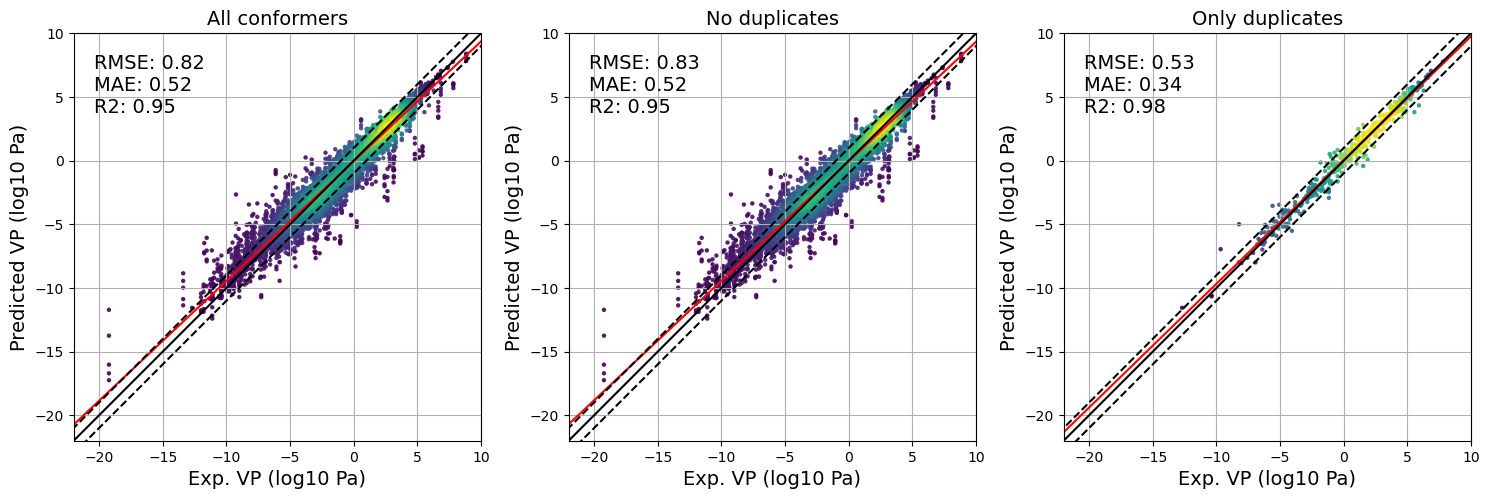

In [10]:
reals_lol = [real_one_to_many_confs, test_y_no_dups, test_y_dups]
preds_lol = [preds_one_to_many_same_mol, preds_one_to_many_same_mol_no_dups, preds_dups]
density_plot_multiple(reals_lol, preds_lol,titles = ['All conformers', 'No duplicates', 'Only duplicates'], bounds = [-22,10],print_stats=False)

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_single_custom_local(real, prediction,  bounds=None, title=None, name=None):
    
    fig, ax = plt.subplots(figsize=(10, 8))   
    
    RMSE, MAE, EBO, KT,median_AE = getStatValues_v2(real, prediction)
      
    
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
    
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])
    
    sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)
    
    ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
    ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
    ax.grid(True, which="both")
    
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    
    ax.axis([lower, upper, lower, upper])
    
    text_box = ax.text(0.05, 0.95, f'RMSE: {RMSE:.2f}  \nMedian AE: {median_AE:.2f}\nMean AE: {MAE:.2f} \nFraction errors < 1: {EBO:.2f} \nKendalls Tau: {KT:.2f}', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if title is not None:
        ax.set_title(title, fontsize=14)
    
    ax.set_aspect('equal', 'box')
    
    if name:
        plt.savefig(name+'.png', dpi=600)
    
    plt.show()

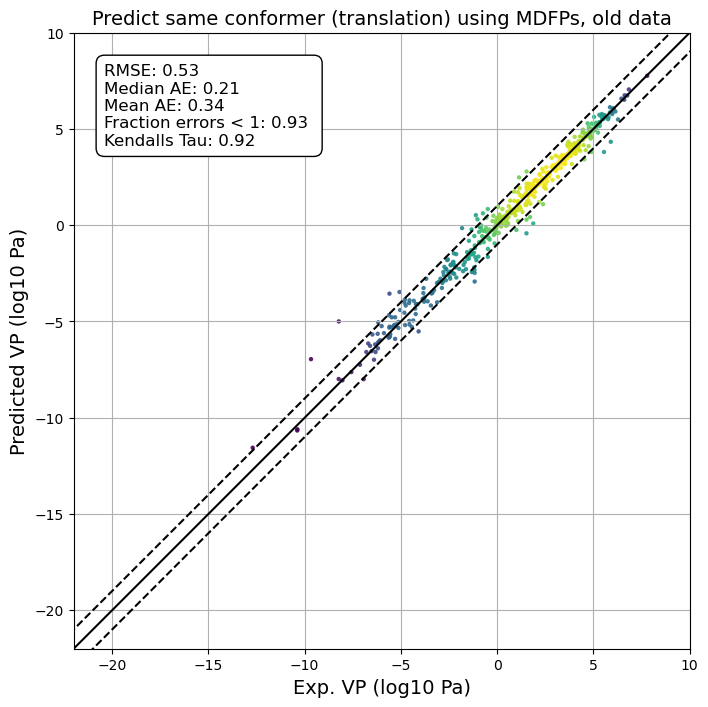

In [25]:
density_plot_single_custom_local(real = test_y_dups, prediction = preds_dups,bounds=[-22,10],title='Predict same conformer (translation) using MDFPs, old data',name='tmp_data/only_duplicates')

In [ ]:
#concat the two dataframes
import pandas as pd
data_full = pd.concat([df_mdfps,df_new_confs])

In [ ]:
#get all molregnos from data_full that appear 5 or more times
import pandas as pd
molregnos = data_full['molregno'].value_counts()
molregnos = molregnos[molregnos == 6].index.tolist()
print(f'{len(molregnos)} molregnos with 6 conformers')
df_6_confs = data_full[data_full['molregno'].isin(molregnos)].copy()
#make another df with the rest of the data
#split data in six folds so that each fold has at least one conformer of each molregno
df_6_confs['fold'] = np.nan
for molregno in molregnos:
    #assign a fold to each conformer of this molregno
    df_6_confs.loc[df_6_confs['molregno'] == molregno, 'fold'] = np.arange(6)
df_6_confs['fold'] = df_6_confs['fold'].astype(int)
#check if each fold has at least one conformer of each molregno
for molregno in molregnos:
    if len(df_6_confs[df_6_confs['molregno'] == molregno]['fold'].unique()) != 6:
        print(f'molregno {molregno} not in each fold')
        break
train_base = data_full[~data_full['molregno'].isin(molregnos)].copy()
#check overlap between train_base and df_6_confs for confids 
train_base_confids = train_base['confid'].tolist()
df_6_confs_confids = df_6_confs['confid'].tolist()
overlap = set(train_base_confids).intersection(df_6_confs_confids)
print(f'Overlap: {len(overlap)}')
output = ([],[],[],[])
for fold in range(6):
    #get test data for this fold
    test = df_6_confs[df_6_confs['fold'] == fold].copy()
    #the rest to train
    train = df_6_confs[df_6_confs['fold'] != fold].copy()
    #add train_base to train
    train = pd.concat([train, train_base], ignore_index=True)
    
    #get the mdfps and vps of the conformers for this fold
    test_x = np.array(test['mdfp'].tolist())
    test_y = np.array(test['vp_log10pa'].tolist())
    train_x = np.array(train['mdfp'].tolist())
    train_y = np.array(train['vp_log10pa'].tolist())

    #check if no overlap of confids between test and train
    if len(set(test['confid']).intersection(set(train['confid']))) != 0:
        print('overlap between test and train: ', len(set(test['confid']).intersection(set(train['confid']))))
        break

    #get molregnos test
    molregnos_test = test['molregno'].tolist()
    #get confids test
    confids_test = test['confid'].tolist()
   

    # Create DMatrix for training and testing
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    output[2].append(molregnos_test)
    output[3].append(confids_test)


1692 molregnos with 6 conformers
Overlap: 0


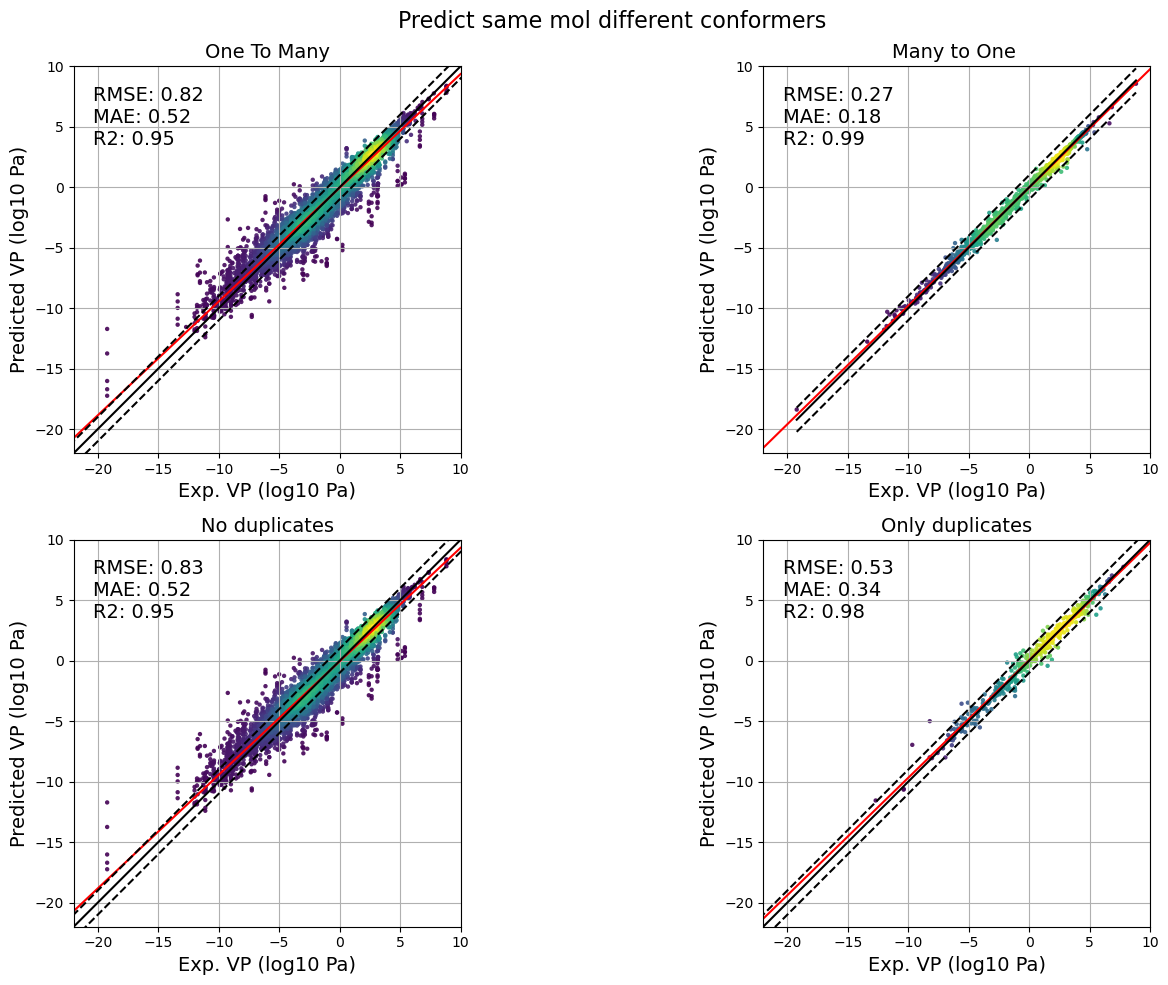

In [ ]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp_log10pa': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction_train_5_confs_pred_6 = df_preds['pred'].tolist()
real_train_5_confs_pred_6 = df_preds['vp_log10pa'].tolist()

reals_lol = [real_one_to_many_confs, real_train_5_confs_pred_6,test_y_no_dups, test_y_dups]
preds_lol = [preds_one_to_many_same_mol, prediction_train_5_confs_pred_6,preds_one_to_many_same_mol_no_dups, preds_dups]
density_plot_multiple(reals_lol, preds_lol,titles = ['One To Many','Many to One ','No duplicates', 'Only duplicates'], bounds = [-22,10],print_stats=False,global_title="Predict same mol different conformers")


So predicting the vapour pressure for a different starting conformer of the same molecule works quite well when looking at the correlation, but there is still quite a big RMSE.

### Data augmentation

In [ ]:
params = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
vps,preds,molregnos,confids = train_pred_xgboost(data_full,params,return_confids=True)
df_preds = pd.DataFrame({'vp_log10pa': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction_many_to_many = df_preds['pred'].tolist()
real_many_to_many = df_preds['vp_log10pa'].tolist()

Data augmentation resulted in a decrease in error metrics RMSE and MAE but not much in correlation

now look at the four scenarios for new mols:
1. many to many (split by molregno on data_full)
2. many to one (train on df_new_confs, predict df_mdfps. Look at with and without removing duplictes)
3. one to many (train on df_mdfps, pred df_new_confs)
4. one to one (split by molregno on df_mdfps)



In [ ]:
#fairest if we compare the same number of conformers. So maybe first split data_full into five folds. For each fold, check how many unique molregnos and how many conf_ids
from sklearn.model_selection import GroupKFold
from sklearn.utils import shuffle
# Create an empty list to store the indices of each fold
fold_indices = []
gkf = GroupKFold(n_splits=5)
# Group the data by 'molregno'
groups = data_full['molregno']
params_one = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
params_many = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
# Iterate over each fold
outputs = ([],[],[],[],[],[],[],[],[],[],[])


print(f'Fold shuffle {i+1} of 3')
shuffled_data = shuffle(data_full, random_state=i)

for train_idx, test_idx in gkf.split(shuffled_data, groups=shuffled_data['molregno']):
    #first we split the whole data by molregno
    train_all = shuffled_data.iloc[train_idx]
    test_all = shuffled_data.iloc[test_idx]

    #then we make a seperate set with only one conformer per molregno
    molregnos_train = train_all['molregno'].unique().tolist()
    confids_train = []
    for molregno in molregnos_train:
        confids = train_all[train_all['molregno'] == molregno]['confid'].tolist()
        confids_train.append(np.random.choice(confids, 1)[0])
    train_one_to_one = train_all[train_all['confid'].isin(confids_train)].copy()

    molregnos_test_one = test_all['molregno'].unique().tolist()
    molregnos_test_many = test_all['molregno'].tolist()
    confids_test_all = test_all['confid'].tolist()
    confids_test_one = []
    confids_test_many = test_all['confid'].tolist()
    for molregno in molregnos_test_one:
        confids = test_all[test_all['molregno'] == molregno]['confid'].tolist()       
        confids_test_one.append(np.random.choice(confids, 1)[0])
    test_one_to_one = test_all[test_all['confid'].isin(confids_test_one)].copy()

    train_x_one = np.array(train_one_to_one['mdfp'].tolist())
    train_y_one = np.array(train_one_to_one['vp_log10pa'].tolist())
    dtrain_one = xgb.DMatrix(train_x_one, label=train_y_one)
    
    test_x_one = np.array(test_one_to_one['mdfp'].tolist())
    test_y_one = np.array(test_one_to_one['vp_log10pa'].tolist())
    dtest_one = xgb.DMatrix(test_x_one, label=test_y_one)

    train_x_many = np.array(train_all['mdfp'].tolist())
    train_y_many = np.array(train_all['vp_log10pa'].tolist())
    dtrain_many = xgb.DMatrix(train_x_many, label=train_y_many)

    test_x_many = np.array(test_all['mdfp'].tolist())
    test_y_many = np.array(test_all['vp_log10pa'].tolist())
    dtest_many = xgb.DMatrix(test_x_many, label=test_y_many)

    molregnos_test_one = test_one_to_one['molregno'].tolist()
    confids_test_many = test_all['molregno'].tolist()


    #now for all four, train models and predict
    model_one = xgb.train(
        params_one,
        dtrain_one,
        num_boost_round=999,
        verbose_eval=False
    )
    model_many = xgb.train(
        params_many,
        dtrain_many,
        num_boost_round=999,
        verbose_eval=False
    )
    preds_one_to_one = model_one.predict(dtest_one)
    preds_many_to_many = model_many.predict(dtest_many)

    preds_one_to_many = model_one.predict(dtest_many)
    preds_many_to_one = model_many.predict(dtest_one)

    outputs[0].append(preds_one_to_one)
    outputs[1].append(preds_many_to_many)
    outputs[2].append(preds_one_to_many)
    outputs[3].append(preds_many_to_one)

    outputs[4].append(test_y_one)
    outputs[5].append(test_y_many)

    outputs[6].append(molregnos_test_one)
    outputs[7].append(molregnos_test_many)

    outputs[8].append(confids_test_one)
    outputs[9].append(confids_test_many)

    #check output lengths: all 'many' should be equal and all 'one' should be equal
    if len(preds_one_to_one) != len(preds_many_to_one) != len(test_y_one) != len(molregnos_test_one) != len(confids_test_one):
        print('lengths not equal')
        print(len(preds_one_to_one), len(preds_many_to_one), len(test_y_one), len(molregnos_test_one), len(confids_test_one))
        break
    if len(preds_many_to_many) != len(preds_one_to_many) != len(test_y_many) != len(molregnos_test_many) != len(confids_test_many):
        print('lengths not equal')
        print(len(preds_many_to_many), len(preds_one_to_many), len(test_y_many), len(molregnos_test_many), len(confids_test_many))
        break

    #check overlap train and test molregno
    if len(set(molregnos_train).intersection(set(molregnos_test_one))) != 0:
        print('overlap between train and test molregnos')
        break
    if len(set(molregnos_train).intersection(set(molregnos_test_many))) != 0:
        print('overlap between train and test molregnos')
        break

NameError: name 'data_full' is not defined

In [ ]:
# ys,molregnos = [],[]
# for i in range(2):
#     print(f'Fold shuffle {i+1} of 3')
#     shuffled_data = shuffle(data_full, random_state=i)
#     for train_idx, test_idx in gkf.split(shuffled_data, groups=shuffled_data['molregno']):

#         train_all = shuffled_data.iloc[train_idx]
#         test_all = shuffled_data.iloc[test_idx]

#         molregnos_train = train_all['molregno'].unique().tolist()
#         #make new df with random pick one confid per molregno
#         confids_train = []
#         for molregno in molregnos_train:
#             confids = train_all[train_all['molregno'] == molregno]['confid'].tolist()
#             confids_train.append(np.random.choice(confids, 1)[0])
#         train_one_to_one = train_all[train_all['confid'].isin(confids_train)].copy()

#         molregnos_test_one = test_all['molregno'].unique().tolist()
#         confids_test_all = test_all['confid'].tolist()
#         confids_test_one = []
#         for molregno in molregnos_test_one:
#             confids = test_all[test_all['molregno'] == molregno]['confid'].tolist()       
#             confids_test_one.append(np.random.choice(confids, 1)[0])
#         test_one_to_one = test_all[test_all['confid'].isin(confids_test_one)].copy()

        
#         test_y_one = np.array(test_one_to_one['vp_log10pa'].tolist())
#         molregnos_test_one = test_one_to_one['molregno'].tolist()

#         ys.extend(test_y_one)
#         molregnos.extend(molregnos_test_one)


       


#         # outputs[4].append(test_y_one)

#         # outputs[6].append(molregnos_test_one)

#         # outputs[8].append(confids_test_one)


Fold shuffle 1 of 3
Fold shuffle 2 of 3


In [ ]:
# test_all.sort_values(by=['molregno','confid'], inplace=True)
# test_all

/tmp/ipykernel_3014643/2489078880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_all.sort_values(by=['molregno','confid'], inplace=True)


,confid,molregno,mdfp,vp_log10pa
32,1153,10,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -19.82802423150...",4.227887
3335,7679,10,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -19.84148596415...",4.227887
3303,7680,10,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -19.83276635553...",4.227887
3294,7681,10,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -19.85873679265...",4.227887
3288,7682,10,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -19.84336266588...",4.227887
...,...,...,...,...
3768,8192,4238,"[9, 0, 1, 0, 0, 0, 0, 0, 0, 0, -124.1868636408...",0.999963
2975,4239,4241,"[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.034004099168...",-5.356584
2024,6377,4241,"[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.029108780740...",-5.356584
2966,4241,4243,"[5, 0, 0, 0, 3, 0, 0, 1, 0, 0, -0.004587864253...",6.457729


In [ ]:
# molregnos_test_one = test_all['molregno'].unique().tolist()
# confids_test_all = test_all['confid'].tolist()
# confids_test_one = []
# for molregno in molregnos_test_one:
#     confids = test_all[test_all['molregno'] == molregno]['confid'].tolist()       
#     confids_test_one.append(np.random.choice(confids, 1)[0])
# test_one_to_one = test_all[test_all['confid'].isin(confids_test_one)].copy()
# test_one_to_one.sort_values(by=['molregno','confid'], inplace=True)
# test_one_to_one

,confid,molregno,mdfp,vp_log10pa
32,1153,10,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -19.82802423150...",4.227887
34,1155,12,"[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -105.003804343...",-3.104246
2029,6382,13,"[6, 2, 0, 0, 0, 0, 0, 0, 1, 0, -1.434640802115...",3.662114
16,4258,15,"[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, -22.73360173406...",4.170000
2567,6952,22,"[6, 1, 0, 0, 0, 0, 0, 0, 0, 0, -34.24137055219...",4.306530
...,...,...,...,...
2918,4222,4224,"[3, 0, 0, 0, 2, 0, 0, 0, 0, 0, -0.149516915282...",6.228128
2961,4223,4225,"[20, 4, 3, 5, 0, 0, 0, 0, 0, 0, -340.441418208...",-9.273038
3768,8192,4238,"[9, 0, 1, 0, 0, 0, 0, 0, 0, 0, -124.1868636408...",0.999963
2975,4239,4241,"[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.034004099168...",-5.356584


In [ ]:
# df_test = pd.DataFrame({'vp_log10pa': ys, 'molregno': molregnos})
# df_testat.sort_values(by=['molregno'], inplace=True)
# df_test

,vp_log10pa,molregno
373,4.100855,1
3389,4.100855,1
3906,-11.744727,6
1067,-11.744727,6
1248,2.698933,7
...,...,...
3759,-3.770000,4242
2538,6.457729,4243
5915,6.457729,4243
294,5.397940,4244


In [ ]:
# test_one_to_one

,confid,molregno,mdfp,vp_log10pa
994,2125,981,"[9, 2, 0, 0, 0, 0, 0, 0, 0, 0, -15.58847436586...",3.180000
381,4644,2889,"[7, 4, 0, 0, 0, 0, 0, 0, 1, 0, 4.7239513030073...",2.717760
7595,12114,4198,"[20, 11, 2, 4, 0, 0, 0, 0, 0, 0, 291.328370527...",-2.758206
2741,3983,3985,"[9, 2, 0, 2, 0, 0, 0, 0, 0, 0, -52.09779417619...",2.929382
6943,11476,2820,"[11, 2, 0, 2, 0, 0, 0, 1, 0, 0, -29.5839790592...",-1.275724
...,...,...,...,...
5167,9600,475,"[11, 2, 0, 1, 0, 0, 0, 0, 0, 0, -36.8077170209...",2.087995
20,2397,2399,"[19, 1, 0, 0, 0, 0, 0, 7, 0, 0, -18.5395562545...",-3.540000
7436,11984,4025,"[10, 2, 1, 0, 0, 0, 1, 0, 0, 0, 9.235316321116...",0.310727
8348,12943,4160,"[13, 6, 1, 1, 0, 0, 1, 0, 0, 0, -66.4731832604...",0.141935


In [ ]:
molregnos_test_one_flat = [item for sublist in outputs[6] for item in sublist]
exp_val_one_flat = [item for sublist in outputs[4] for item in sublist]

# Combine molregnos and experimental values into a DataFrame
df_exp_molregno = pd.DataFrame({'molregno': molregnos_test_one_flat, 'exp_val': exp_val_one_flat})

# Sort the DataFrame by molregno
df_exp_molregno.sort_values(by=['molregno'], inplace=True)

# Display the DataFrame
print(df_exp_molregno)


      molregno    exp_val
6318         1   4.100855
3388         1   4.100855
386          1   4.100855
7135         6 -11.744727
3977         6 -11.744727
...        ...        ...
5609      4243   6.457729
2756      4243   6.457729
337       4244   5.397940
5968      4244   5.397940
3112      4244   5.397940

[8940 rows x 2 columns]


In [ ]:
molregnos_test_many_flat = [item for sublist in outputs[7] for item in sublist]
exp_val_many_flat = [item for sublist in outputs[5] for item in sublist]

# Combine molregnos and experimental values into a DataFrame
df_exp_molregno = pd.DataFrame({'molregno': molregnos_test_one_flat, 'exp_val': exp_val_one_flat})

# Sort the DataFrame by molregno
df_exp_molregno.sort_values(by=['molregno'], inplace=True)

# Display the DataFrame
print(df_exp_molregno)


      molregno    exp_val
6318         1   4.100855
3388         1   4.100855
386          1   4.100855
7135         6 -11.744727
3977         6 -11.744727
...        ...        ...
5609      4243   6.457729
2756      4243   6.457729
337       4244   5.397940
5968      4244   5.397940
3112      4244   5.397940

[8940 rows x 2 columns]


In [ ]:
# test_df = data_full.copy()
# from sklearn.utils import shuffle
# gkf = GroupKFold(n_splits=5)
# for i in range(3):
#     test_df = shuffle(test_df, random_state=i)    
#     groups = test_df['molregno']
#     for train_idx, test_idx in gkf.split(test_df, groups=groups):
#         print(test_idx)

[    6    10    12 ... 14000 14001 14002]
[    0     4    11 ... 13980 13984 13986]
[   20    26    28 ... 13988 13995 13996]
[    3     7     8 ... 13990 13991 13997]
[    1     2     5 ... 13993 13994 13999]
[    0     2     9 ... 13962 13973 13993]
[    3     4     7 ... 13997 13999 14000]
[    5     6    12 ... 13980 13989 13995]
[    1     8    10 ... 13990 13991 13992]
[   11    15    16 ... 13998 14001 14002]
[    6     7     8 ... 13995 13999 14002]
[    0     1     3 ... 13992 13997 13998]
[    9    16    21 ... 13986 13994 14000]
[    2    13    14 ... 13982 13983 13993]
[    4    11    12 ... 13968 13996 14001]


In [ ]:
print(len(outputs[0]), len(outputs[1]), len(outputs[2]), len(outputs[3]), len(outputs[4]), len(outputs[5]), len(outputs[6]), len(outputs[7]), len(outputs[8]), len(outputs[9]))

15 15 15 15 15 15 15 15 15 15


In [ ]:
# for train_idx, test_idx in gkf.split(data_full, groups=data_full['molregno']):
#     print(train_idx, test_idx)

[    0     1     2 ... 14000 14001 14002] [    5     9    13 ... 13988 13995 13996]
[    0     1     2 ... 14000 14001 14002] [   11    18    19 ... 13992 13993 13994]
[    0     1     2 ... 14000 14001 14002] [    4     7     8 ... 13980 13981 13985]
[    1     2     3 ... 14000 14001 14002] [    0    10    17 ... 13984 13986 13997]
[    0     4     5 ... 13995 13996 13997] [    1     2     3 ... 14000 14001 14002]


In [ ]:
# from sklearn.model_selection import RepeatedKFold
# rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
# for i, (train_index, test_index) in enumerate(rkf.split(data_full, groups=data_full['molregno'])):
#     print(train_index, test_index)

[    1     2     3 ... 14000 14001 14002] [    0     6     8 ... 13990 13996 13999]
[    0     1     2 ... 13999 14000 14002] [    3     7    11 ... 13976 13994 14001]
[    0     2     3 ... 13999 14000 14001] [    1     4     5 ... 13995 13997 14002]
[    0     1     2 ... 14000 14001 14002] [   10    15    18 ... 13978 13988 13992]
[    0     1     3 ... 13999 14001 14002] [    2    43    46 ... 13991 13998 14000]
[    1     2     3 ... 13997 13998 14000] [    0     5     9 ... 13999 14001 14002]
[    0     1     3 ... 13999 14001 14002] [    2    10    14 ... 13994 13998 14000]
[    0     1     2 ... 14000 14001 14002] [    8    13    16 ... 13990 13993 13995]
[    0     2     3 ... 14000 14001 14002] [    1    11    24 ... 13984 13986 13996]
[    0     1     2 ... 14000 14001 14002] [    3     4     6 ... 13973 13975 13997]
[    0     1     4 ... 14000 14001 14002] [    2     3    10 ... 13992 13995 13998]
[    0     1     2 ... 14000 14001 14002] [    7    13    24 ... 13974 13981

In [ ]:
# data_full

,confid,molregno,mdfp,vp_log10pa
0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",2.325205
1,2394,2396,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...",2.092080
2,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",0.000000
3,2406,2408,"[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...",-3.822020
4,2411,2413,"[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...",-1.772345
...,...,...,...,...
11018,15530,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -285.66340740...",-4.000000
11019,15531,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -287.85335624...",-4.000000
11020,15529,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -286.74305751...",-4.000000
11021,15532,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -284.52836303...",-4.000000


In [ ]:
# #make random df with three columns, first two random ints between 1 and 10, third column with random letters a-c
# import pandas as pd
# import numpy as np
# df = pd.DataFrame(np.random.randint(1,10,size=(10, 2)), columns=list('AB'))
# df['C'] = np.random.choice(['a','b','c'], 10)
# print(df)
# import numpy as np
# from sklearn.model_selection import RepeatedKFold
# rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
# rkf.get_n_splits(X, y)
# print(rkf)
# for i, (train_index, test_index) in enumerate(rkf.split(df, groups=df['C'])):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

   A  B  C
0  1  7  b
1  7  9  a
2  3  3  c
3  2  7  a
4  3  6  a
5  2  2  c
6  1  1  b
7  6  6  b
8  6  8  b
9  3  3  a
RepeatedKFold(n_repeats=2, n_splits=2, random_state=2652124)
Fold 0:
  Train: index=[0 4 5 6 9]
  Test:  index=[1 2 3 7 8]
Fold 1:
  Train: index=[1 2 3 7 8]
  Test:  index=[0 4 5 6 9]
Fold 2:
  Train: index=[0 1 4 8 9]
  Test:  index=[2 3 5 6 7]
Fold 3:
  Train: index=[2 3 5 6 7]
  Test:  index=[0 1 4 8 9]


In [ ]:
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])

molregnos_test_one = reduce(lambda a,b : list(a)+list(b), outputs[6])
molregnos_test_many = reduce(lambda a,b : list(a)+list(b), outputs[7])

confids_test_one = reduce(lambda a,b : list(a)+list(b), outputs[8])
confids_test_many = reduce(lambda a,b : list(a)+list(b), outputs[9])

In [ ]:
df_pred_one = pd.DataFrame({'pred_from_one': preds_one_to_one, 'pred_from_many': preds_many_to_one,'vp_log10pa': test_y_one, 'molregno': molregnos_test_one, 'confid': confids_test_one})
df_pred_many = pd.DataFrame({'pred_from_one': preds_one_to_many, 'pred_from_many': preds_many_to_many,'vp_log10pa': test_y_many, 'molregno': molregnos_test_many, 'confid': confids_test_many})

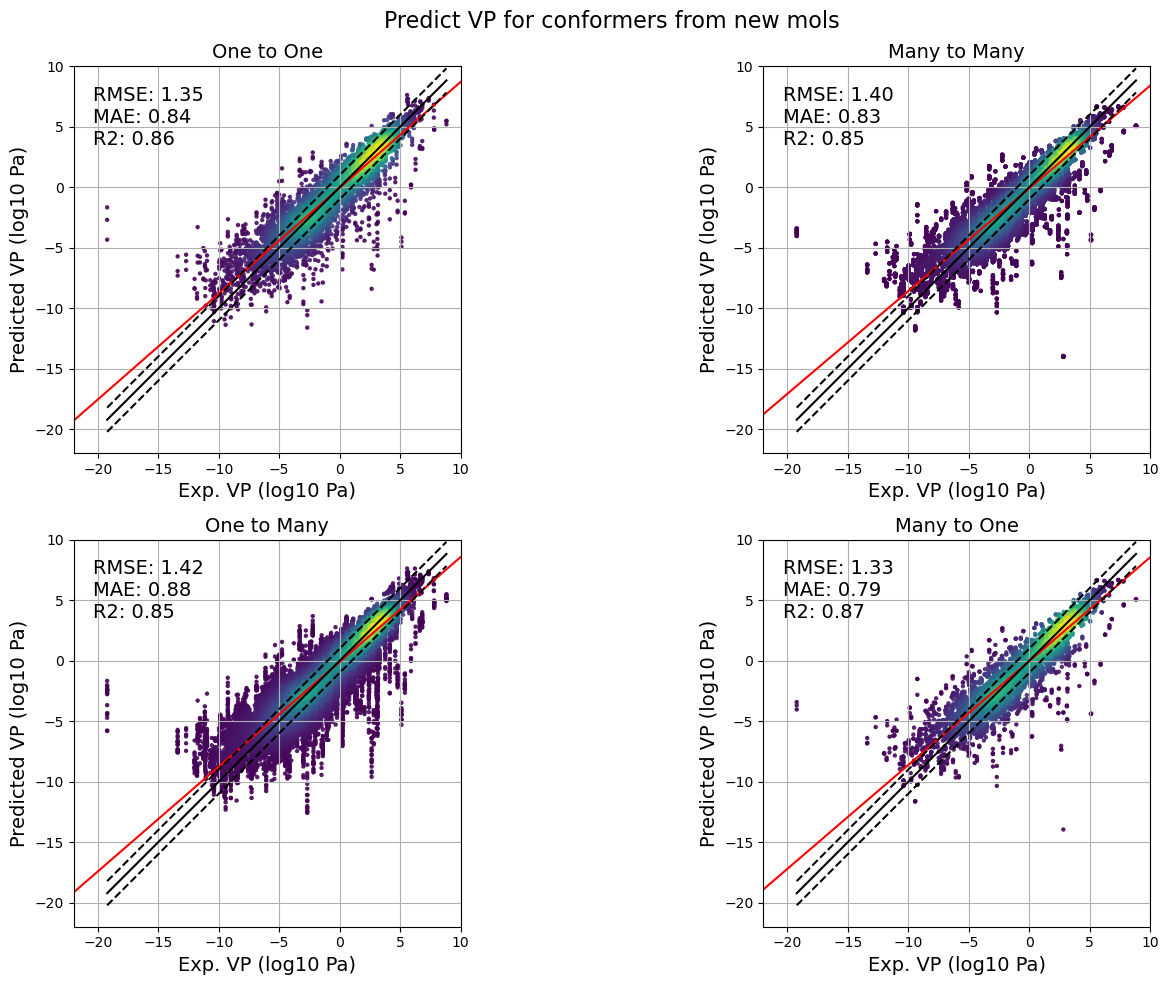

In [ ]:
pred_lol = [preds_one_to_one, preds_many_to_many, preds_one_to_many, preds_many_to_one]
real_lol = [test_y_one, test_y_many, test_y_many, test_y_one]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple(real_lol, pred_lol, titles=titles, bounds = [-22,10], print_stats=False,global_title="Predict VP for conformers from new mols")

In [ ]:
# threshold = 1
# preds = preds_one_to_one
# ys = test_y_one
# count = np.abs(np.array(ys) - np.array(preds)) < threshold
# print(np.mean(np.abs(np.array(ys) - np.array(preds)) < threshold))

0.7013422818791947
0.7013422818791947


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]

    return RMSE, MAE, EBO, KT
    

def density_plot_multiple_custom(reals, predictions,molregnos, print_stats=True, bounds=None, titles=None,global_title=None,print_spearman=False):
    num_plots = len(reals)
    print(f'making {num_plots} plots')
    num_cols = min(num_plots, 3)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed for the grid
    #if you cant devide by 3, but can divide by 2, do two rows
    if num_plots % 3 != 0 and num_plots % 2 == 0:
        num_rows = 2
        num_cols = 2   
    if num_plots == 4:
        num_rows = 2
        num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D
    
    for i in range(num_plots):
        print(f'plot {i+1} of {num_plots}')
        real = reals[i]
        prediction = predictions[i]
        rmses,maes,ebos,kts = [],[],[],[]
        for r,p in zip(real,prediction):
            RMSE, MAE, EBO, KT = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)

        rmse_90_low,rmse_90_high = stats.norm.interval(confidence=0.90, 
                 loc=np.mean(rmses), 
                 scale=stats.sem(rmses)) 
        rmse_mean = np.mean(rmses)
        mae_90_low,mae_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(maes), 
                    scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low,ebo_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(ebos), 
                    scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low,kt_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(kts), 
                    scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        
                                             
        molregno = molregnos[i]

        mrn = [item for sublist in molregno for item in sublist]
        real = [item for sublist in real for item in sublist]
        prediction = [item for sublist in prediction for item in sublist]
        # #make df of these three, and average over molregno
        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()


        print(f'{len(real)} points')
        
        ax = axes[i]
        
        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]
        
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
        import statsmodels.api as sm
        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")
        ax.axis([lower, upper, lower, upper])
        ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', transform=ax.transAxes, fontsize=10, verticalalignment='top')
        if titles is not None and len(titles) > i:
            ax.set_title(titles[i], fontsize=14)
        ax.set_aspect('equal', 'box')
    
    # Remove any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    if global_title is not None:
        fig.suptitle(global_title, fontsize=16)
    
    plt.tight_layout()
    plt.savefig('tmp_data/many_to_many.png', dpi=600)
    plt.show()

making 4 plots
plot 1 of 4
8940 points
plot 2 of 4
42009 points
plot 3 of 4
42009 points
plot 4 of 4
8940 points


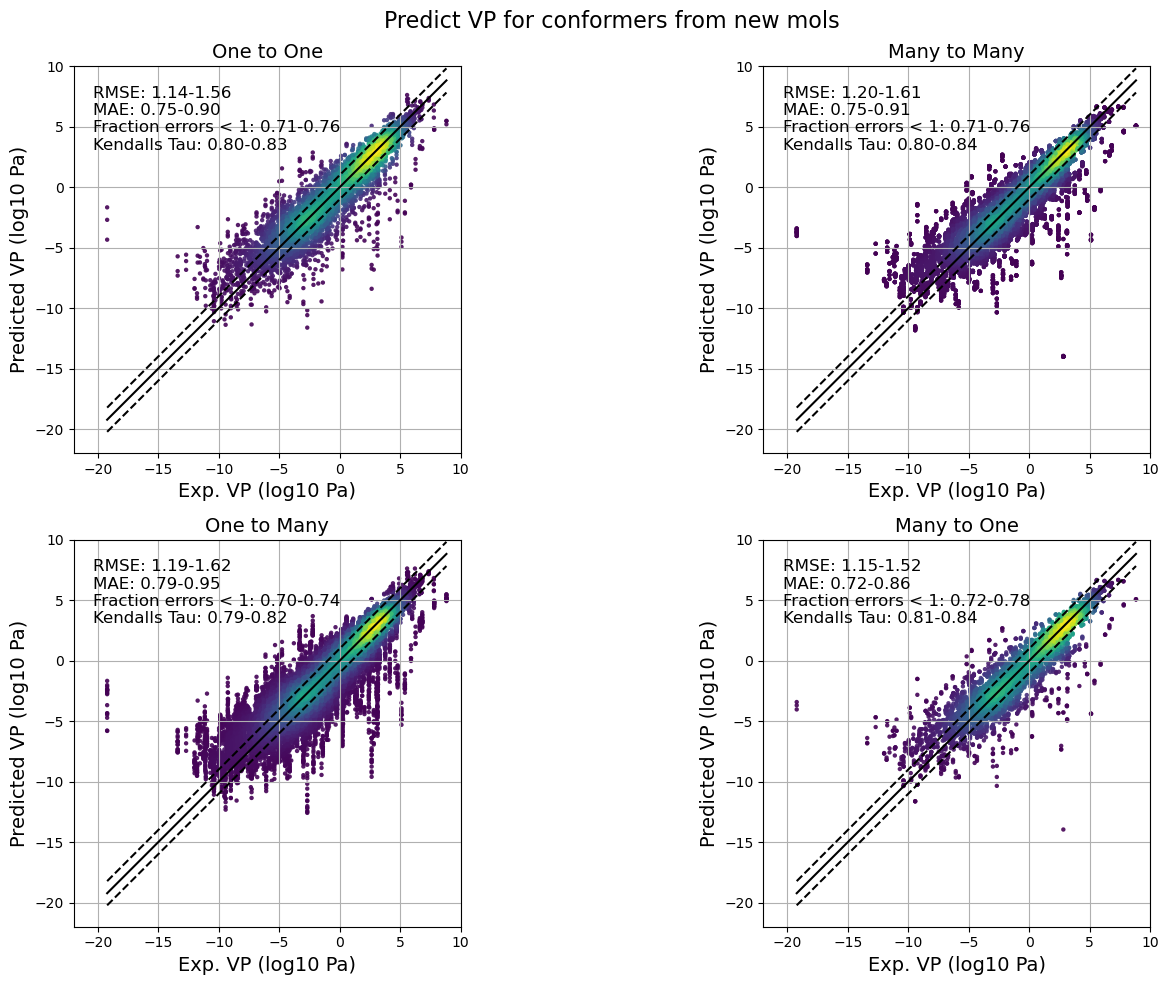

In [ ]:
pred_nested = [outputs[0], outputs[1], outputs[2], outputs[3]]
real_nested = [outputs[4], outputs[5], outputs[5], outputs[4]]
molregnos_nested = [outputs[6], outputs[7], outputs[7], outputs[6]]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple_custom(real_nested, pred_nested, titles=titles, molregnos=molregnos_nested,bounds = [-22,10], print_stats=False,global_title="Predict VP for conformers from new mols")

In [ ]:
preds_one_to_one_nested = outputs[0]
preds_many_to_many_nested = outputs[1]
preds_one_to_many_nested = outputs[2]
preds_many_to_one_nested = outputs[3]
test_y_one_nested = outputs[4]
test_y_many_nested = outputs[5]
molregnos_test_one_nested = outputs[6]
molregnos_test_many_nested = outputs[7]
confids_test_one_nested = outputs[8]
confids_test_many_nested = outputs[9]

df_template = pd.DataFrame({'Prediction': [], 'Experimental': [], 'molregno': [], 'confid': [], 'fold': []})
df_one_to_one_splits = df_template.copy()
df_many_to_many_splits = df_template.copy()
df_one_to_many_splits = df_template.copy()
df_many_to_one_splits = df_template.copy()

for i in range(len(outputs[4])):
    # print(len(outputs[4][i]), len(outputs[0][i]), len(outputs[6][i]), len(outputs[8][i]))
    # print(len(outputs[5][i]), len(outputs[1][i]), len(outputs[7][i]), len(outputs[9][i]))
    df_one_to_one_splits = pd.concat([df_one_to_one_splits, pd.DataFrame({'Prediction': preds_one_to_one_nested[i], 'Experimental': test_y_one_nested[i], 'molregno': molregnos_test_one_nested[i], 'confid': confids_test_one_nested[i], 'fold': [i]*len(outputs[4][i])})], ignore_index=True)
    df_many_to_many_splits = pd.concat([df_many_to_many_splits, pd.DataFrame({'Prediction': preds_many_to_many_nested[i], 'Experimental': test_y_many_nested[i], 'molregno': molregnos_test_many_nested[i], 'confid': confids_test_many_nested[i], 'fold': [i]*len(outputs[5][i])})], ignore_index=True)
    df_one_to_many_splits = pd.concat([df_one_to_many_splits, pd.DataFrame({'Prediction': preds_one_to_many_nested[i], 'Experimental': test_y_many_nested[i], 'molregno': molregnos_test_many_nested[i], 'confid': confids_test_many_nested[i], 'fold': [i]*len(outputs[5][i])})], ignore_index=True)
    df_many_to_one_splits = pd.concat([df_many_to_one_splits, pd.DataFrame({'Prediction': preds_many_to_one_nested[i], 'Experimental': test_y_one_nested[i], 'molregno': molregnos_test_one_nested[i], 'confid': confids_test_one_nested[i], 'fold': [i]*len(outputs[4][i])})], ignore_index=True)

In [ ]:
df_one_to_one_splits.sort_values(by=['molregno', 'fold'], inplace=True)
df_one_to_one_splits

,Prediction,Experimental,molregno,confid,fold
386,4.253705,4.100855,1.0,14523.0,0.0
3388,3.728797,4.100855,1.0,6873.0,5.0
6318,4.087109,4.100855,1.0,6134.0,10.0
1160,-5.664207,-11.744727,6.0,3422.0,1.0
3977,-3.298254,-11.744727,6.0,1849.0,6.0
...,...,...,...,...,...
5609,6.621807,6.457729,4243.0,8695.0,9.0
8596,6.360308,6.457729,4243.0,11563.0,14.0
337,-2.079527,5.397940,4244.0,14124.0,0.0
3112,-2.174476,5.397940,4244.0,10772.0,5.0


In [ ]:
print(len(df_one_to_one_splits['molregno'].unique()))
for i in range(15):
    df_preds_one_to_one = df_one_to_one_splits[df_one_to_one_splits['fold'] == i].groupby('molregno').mean()
    print(len(df_preds_one_to_one))

2980
596
596
596
596
596
596
596
596
596
596
596
596
596
596
596


In [ ]:
#make nested lists for pred and real, nested by split index
preds_one_to_one_nested = []
for i in range(15):
    df_preds_one_to_one = df_one_to_one_splits[df_one_to_one_splits['fold'] == i].groupby('molregno').mean()
    preds_tmp = df_preds_one_to_one['Prediction'].tolist()
    preds_one_to_one_nested.append(preds_tmp)
    print(len(preds_tmp))
print(len(preds_one_to_one_nested), len(preds_one_to_one_nested[0]))

596
596
596
596
596
596
596
596
596
596
596
596
596
596
596
15 596


In [ ]:
# preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
# preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
# preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
# preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
# test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
# test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])

# molregnos_test_one = reduce(lambda a,b : list(a)+list(b), outputs[6])
# molregnos_test_many = reduce(lambda a,b : list(a)+list(b), outputs[7])

# confids_test_one = reduce(lambda a,b : list(a)+list(b), outputs[8])
# confids_test_many = reduce(lambda a,b : list(a)+list(b), outputs[9])

In [ ]:
df_one_to_one_splits.sort_values(by=['molregno', 'confid'], inplace=True)
df_one_to_one_splits

,Prediction,Experimental,molregno,confid,fold
6318,4.087109,4.100855,1.0,6134.0,10.0
3388,3.728797,4.100855,1.0,6873.0,5.0
386,4.253705,4.100855,1.0,14523.0,0.0
7135,-6.232427,-11.744727,6.0,1183.0,11.0
3977,-3.298254,-11.744727,6.0,1849.0,6.0
...,...,...,...,...,...
5609,6.621807,6.457729,4243.0,8695.0,9.0
8596,6.360308,6.457729,4243.0,11563.0,14.0
3112,-2.174476,5.397940,4244.0,10772.0,5.0
337,-2.079527,5.397940,4244.0,14124.0,0.0


In [ ]:
preds,reals,molregnos = [],[],[]
for i in range(15):
    df_tmp = df_one_to_one_splits[df_one_to_one_splits['fold'] == i].groupby('molregno').mean()
    preds.append(df_tmp['Prediction'].tolist())
    reals.append(df_tmp['Experimental'].tolist())
    molregnos.append(df_tmp.index.tolist())
print(len(preds), len(reals), len(molregnos))
preds_flat = reduce(lambda a,b : list(a)+list(b), preds)
reals_flat = reduce(lambda a,b : list(a)+list(b), reals)
molregnos_flat = reduce(lambda a,b : list(a)+list(b), molregnos)
df_test = pd.DataFrame({'Prediction': preds_flat, 'Experimental': reals_flat, 'molregno': molregnos_flat})
df_test.sort_values(by=['molregno'], inplace=True)
df_test


15 15 15


,Prediction,Experimental,molregno
0,4.253705,4.100855,1.0
5960,4.087109,4.100855,1.0
2980,3.728797,4.100855,1.0
3576,-3.298254,-11.744727,6.0
6556,-6.232427,-11.744727,6.0
...,...,...,...
2979,6.531327,6.457729,4243.0
8939,6.360308,6.457729,4243.0
6555,-1.122863,5.397940,4244.0
595,-2.079527,5.397940,4244.0


596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
596 596 596 596
8940 42009
15 15 15 15
15 15 15 15
making 4 plots
plot 1 of 4
2980 points
plot 2 of 4
2980 points
plot 3 of 4
2980 points
plot 4 of 4
2980 points


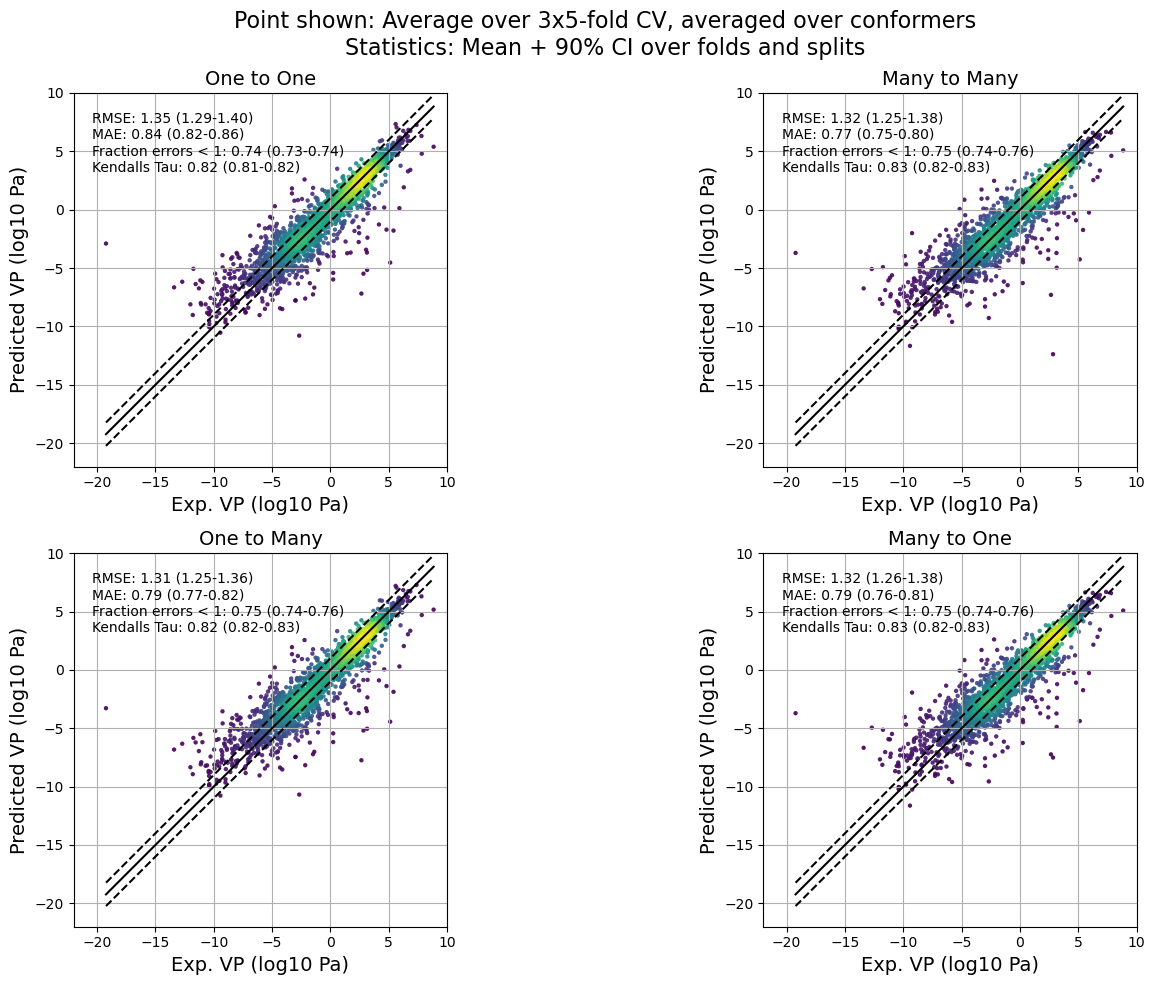

In [ ]:
#make nested lists for pred and real, nested by split index
preds_one_to_one_nested, preds_many_to_many_nested, preds_one_to_many_nested, preds_many_to_one_nested = [], [], [], []
test_y_one_to_one_nested, test_y_many_to_many_nested, test_y_one_to_many_nested, test_y_many_to_one_nested = [], [], [], []

molregnos_one_to_one_nested, molregnos_many_to_many_nested, molregnos_one_to_many_nested, molregnos_many_to_one_nested = [], [], [], []
for i in range(15):
    df_preds_one_to_one = df_one_to_one_splits[df_one_to_one_splits['fold'] == i].groupby('molregno').mean()
    df_preds_many_to_many = df_many_to_many_splits[df_many_to_many_splits['fold'] == i].groupby('molregno').mean()
    df_preds_one_to_many = df_one_to_many_splits[df_one_to_many_splits['fold'] == i].groupby('molregno').mean()
    df_preds_many_to_one = df_many_to_one_splits[df_many_to_one_splits['fold'] == i].groupby('molregno').mean()

    preds_one_to_one = df_preds_one_to_one['Prediction'].tolist()
    preds_many_to_many = df_preds_many_to_many['Prediction'].tolist()
    preds_one_to_many = df_preds_one_to_many['Prediction'].tolist()
    preds_many_to_one = df_preds_many_to_one['Prediction'].tolist()

    test_one_to_one = df_preds_one_to_one['Experimental'].tolist()
    test_many_to_many = df_preds_many_to_many['Experimental'].tolist()
    test_one_to_many = df_preds_one_to_many['Experimental'].tolist()
    test_many_to_one = df_preds_many_to_one['Experimental'].tolist()

    molregnos_one_to_one = df_preds_one_to_one.index.tolist()
    molregnos_many_to_many = df_preds_many_to_many.index.tolist()
    molregnos_one_to_many = df_preds_one_to_many.index.tolist()
    molregnos_many_to_one = df_preds_many_to_one.index.tolist()



    preds_one_to_one_nested.append(preds_one_to_one)
    preds_many_to_many_nested.append(preds_many_to_many)
    preds_one_to_many_nested.append(preds_one_to_many)
    preds_many_to_one_nested.append(preds_many_to_one)

    molregnos_one_to_one_nested.append(molregnos_one_to_one)
    molregnos_many_to_many_nested.append(molregnos_many_to_many)
    molregnos_one_to_many_nested.append(molregnos_one_to_many)
    molregnos_many_to_one_nested.append(molregnos_many_to_one)

    

    print(len(preds_one_to_one), len(preds_many_to_many), len(preds_one_to_many), len(preds_many_to_one))

    test_y_one_to_one_nested.append(test_one_to_one)
    test_y_many_to_many_nested.append(test_many_to_many)
    test_y_one_to_many_nested.append(test_one_to_many)
    test_y_many_to_one_nested.append(test_many_to_one)

    print(len(test_y_one), len(test_y_many))
    

print(len(preds_one_to_one_nested),len(preds_many_to_one_nested),len(test_y_one_to_one_nested),len(test_y_many_to_many_nested))
print(len(preds_many_to_many_nested),len(preds_one_to_many_nested),len(test_y_many_to_many_nested),len(test_y_one_to_many_nested))

pred_nested = [preds_one_to_one_nested, preds_many_to_many_nested, preds_one_to_many_nested, preds_many_to_one_nested]
real_nested = [test_y_one_to_one_nested, test_y_many_to_many_nested, test_y_one_to_many_nested, test_y_many_to_one_nested]
molregnos_nested = [molregnos_one_to_one_nested, molregnos_many_to_many_nested, molregnos_one_to_many_nested, molregnos_many_to_one_nested]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple_custom(real_nested, pred_nested, titles=titles, molregnos=molregnos_nested,bounds = [-22,10], print_stats=False,global_title="Point shown: Average over 3x5-fold CV, averaged over conformers\nStatistics: Mean + 90% CI over folds and splits")

In [ ]:
rmses = []
for p,t in zip(preds_one_to_one_nested,test_y_one_to_one_nested):
    rmses.append(mean_squared_error(np.array(p), np.array(t), squared=False))
print(rmses)
print(min(rmses), max(rmses), np.mean(rmses))
ci_low,ci_high = st.t.interval(confidence=0.90, df=len(rmses)-1, 
			loc=np.mean(rmses), 
			scale=st.sem(rmses)) 
print(ci_low,ci_high)

[1.3388822304461947, 1.4625173000318736, 1.1420504935325797, 1.2574655789885831, 1.4667526977850904, 1.3520789657989685, 1.5483086366746064, 1.2293143666961368, 1.2208235618401586, 1.4291068782430696, 1.3240113590981761, 1.5638202285643117, 1.2681886893030065, 1.1926491940092243, 1.4244715729109307]
1.1420504935325797 1.5638202285643117 1.3480294502615275
1.2886856938886675 1.4073732066343876


In [ ]:
import numpy as np 
import scipy.stats as st 

# define sample data 
gfg_data = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 
			3, 4, 4, 5, 5, 5, 6, 7, 8, 10] 

# create 90% confidence interval 
st.t.interval(confidence=0.90, df=len(gfg_data)-1, 
			loc=np.mean(gfg_data), 
			scale=st.sem(gfg_data)) 


(2.962098014195961, 4.837901985804038)

In [ ]:
test = df_one_to_one_splits[df_one_to_one_splits['fold'] == i]
test.sort_values(by=['molregno', 'confid'], inplace=True)
test

/tmp/ipykernel_3014643/2107185453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values(by=['molregno', 'confid'], inplace=True)


,Prediction,Experimental,molregno,confid,fold
8364,2.737067,2.092080,10.0,7679.0,14.0
8804,2.326093,2.147068,12.0,1155.0,14.0
8799,-2.615679,-2.470000,13.0,6380.0,14.0
8437,-0.967161,-0.552878,15.0,1158.0,14.0
8937,1.487099,0.310727,22.0,6952.0,14.0
...,...,...,...,...,...
8630,-3.457335,-3.340000,4224.0,9417.0,14.0
8399,-1.475854,-2.080000,4225.0,11071.0,14.0
8877,-4.917286,-3.493081,4238.0,8192.0,14.0
8817,-4.574927,-6.886094,4241.0,6377.0,14.0


In [ ]:
test2 = test.groupby('molregno').mean()
test2.sort_values(by=['molregno', 'confid'], inplace=True)
test2

,Prediction,Experimental,confid,fold
molregno,,,,
10.0,2.737067,2.092080,7679.0,14.0
12.0,2.326093,2.147068,1155.0,14.0
13.0,-2.615679,-2.470000,6380.0,14.0
15.0,-0.967161,-0.552878,1158.0,14.0
22.0,1.487099,0.310727,6952.0,14.0
...,...,...,...,...
4224.0,-3.457335,-3.340000,9417.0,14.0
4225.0,-1.475854,-2.080000,11071.0,14.0
4238.0,-4.917286,-3.493081,8192.0,14.0


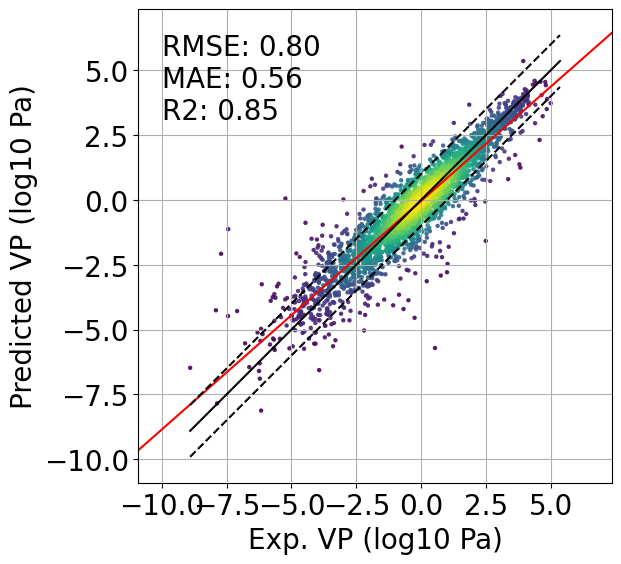

In [ ]:
preds_one_to_one_flat = reduce(lambda a,b : list(a)+list(b), preds_one_to_one_nested)
test_y_one_to_one_flat = reduce(lambda a,b : list(a)+list(b), test_y_one_to_one_nested)
molregnos_one_to_one_flat = reduce(lambda a,b : list(a)+list(b), molregnos_one_to_one_nested)
df_test = pd.DataFrame({'Prediction': preds_one_to_one_flat, 'Experimental': test_y_one_to_one_flat, 'molregno': molregnos_one_to_one_flat})
df_test = df_test.groupby('molregno').mean()
df_test
density_plot(df_test['Experimental'].tolist(), df_test['Prediction'].tolist(), print_stats=False)

In [ ]:
df_test = pd.DataFrame({'Prediction': preds_one_to_one_flat, 'Experimental': test_y_one_to_one_flat, 'molregno': molregnos_one_to_one_flat})
df_test[df_test['molregno'] == 1]

,Prediction,Experimental,molregno
0,-2.229685,-2.850000,1.0
2980,0.497687,0.425932,1.0
5960,3.833511,3.104231,1.0


In [ ]:
print(len(real_nested), len(pred_nested))
print(len(real_nested[0]), len(pred_nested[0]))
print(len(real_nested[0][0]), len(pred_nested[0][0]))   
print(len(real_nested[1][0]), len(pred_nested[1][0]))   

4 4
15 15
596 596
596 596


In [ ]:
len(df_preds_one_to_one)

596

In [ ]:
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])

molregnos_test_one = reduce(lambda a,b : list(a)+list(b), outputs[6])
molregnos_test_many = reduce(lambda a,b : list(a)+list(b), outputs[7])

confids_test_one = reduce(lambda a,b : list(a)+list(b), outputs[8])
confids_test_many = reduce(lambda a,b : list(a)+list(b), outputs[9])

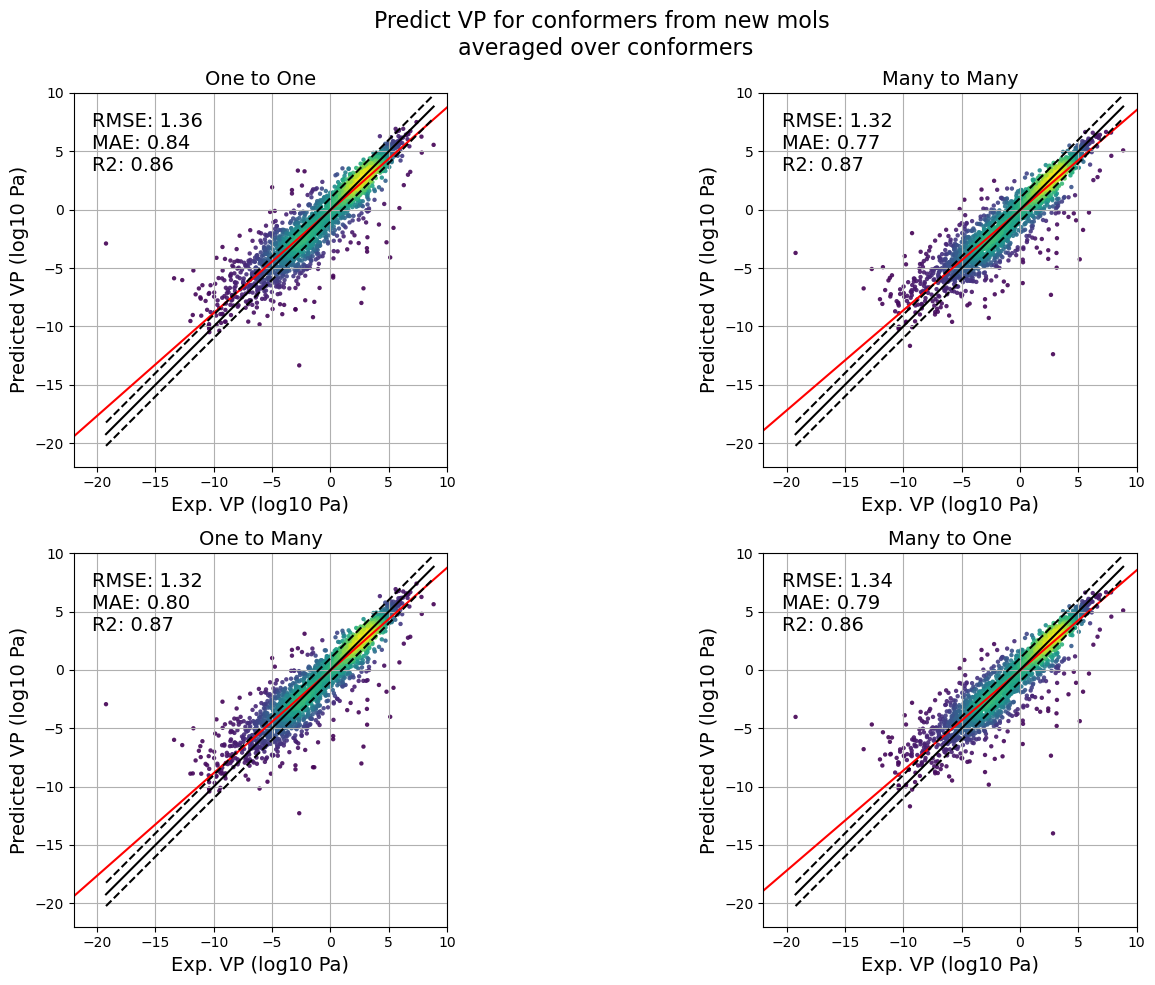

In [ ]:
#repeat with averging for the many. 
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])
molregnos_one = reduce(lambda a,b : list(a)+list(b), outputs[6])
molregnos_many = reduce(lambda a,b : list(a)+list(b), outputs[7])
confids_test_one = reduce(lambda a,b : list(a)+list(b), outputs[8])
confids_test_all = reduce(lambda a,b : list(a)+list(b), outputs[9])

df_preds_one_to_one = pd.DataFrame({'vp_log10pa': test_y_one, 'pred': preds_one_to_one, 'confid': confids_test_one, 'molregno': molregnos_one})
df_preds_one_to_one = df_preds_one_to_one.groupby('molregno').mean()
preds_one_to_one_mean = df_preds_one_to_one['pred'].tolist()
test_y_one_mean = df_preds_one_to_one['vp_log10pa'].tolist()

df_preds_many_to_many = pd.DataFrame({'vp_log10pa': test_y_many, 'pred': preds_many_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_many_to_many = df_preds_many_to_many.groupby('molregno').mean()
preds_many_to_many_mean = df_preds_many_to_many['pred'].tolist()
test_y_many_mean = df_preds_many_to_many['vp_log10pa'].tolist()

df_preds_one_to_many = pd.DataFrame({'vp_log10pa': test_y_many, 'pred': preds_one_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_one_to_many = df_preds_one_to_many.groupby('molregno').mean()
preds_one_to_many_mean = df_preds_one_to_many['pred'].tolist()
test_y_many_mean = df_preds_one_to_many['vp_log10pa'].tolist()

df_preds_many_to_one = pd.DataFrame({'vp_log10pa': test_y_one, 'pred': preds_many_to_one, 'confid': confids_test_one, 'molregno': molregnos_one})
df_preds_many_to_one = df_preds_many_to_one.groupby('molregno').mean()
preds_many_to_one_mean = df_preds_many_to_one['pred'].tolist()
test_y_one_mean = df_preds_many_to_one['vp_log10pa'].tolist()

pred_lol = [preds_one_to_one_mean, preds_many_to_many_mean, preds_one_to_many_mean, preds_many_to_one_mean]
real_lol = [test_y_one_mean, test_y_many_mean, test_y_many_mean, test_y_one_mean]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple(real_lol, pred_lol, titles=titles, bounds = [-22,10], print_stats=False,global_title="Predict VP for conformers from new mols \naveraged over conformers")

In [ ]:
kkk

In [ ]:
df_preds_many_to_many.head()
df_investigate_conformer_effect = df_preds_many_to_many.copy()
#merge df_investigate_conformer_effect and df_preds_one_to_one on molregno
df_investigate_conformer_effect = df_investigate_conformer_effect.merge(df_preds_one_to_one, how='left', on='molregno')
df_investigate_conformer_effect
#okay this is not good, why are the vps not the same?


,vp_log10pa_x,pred_x,confid_x,vp_log10pa_y,pred_y,confid_y
molregno,,,,,,
1,4.100855,4.017823,4744.500000,2.540771,2.767467,7191.0
6,-11.744727,-4.922967,8749.666667,0.602060,-0.078619,10254.0
7,2.698933,2.432965,10289.166667,-3.699007,-3.089914,12117.0
8,-3.053323,-3.044069,5986.000000,-4.999998,-5.600642,1151.0
9,3.591625,3.430883,6008.666667,-0.330000,-0.991321,6979.0
...,...,...,...,...,...,...
4240,-4.301899,-4.240690,8184.666667,-4.735219,-1.924039,8973.0
4241,-5.356584,-5.211004,5308.000000,-0.040996,0.905147,6377.0
4242,-3.770000,-3.578028,9625.833333,-1.166216,-1.529205,10704.0


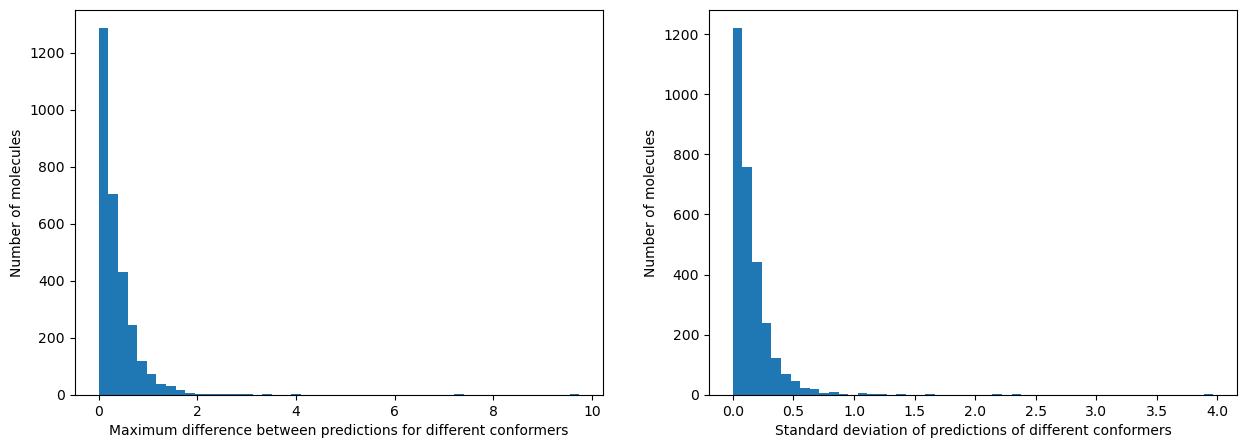

In [ ]:
df_preds_many_to_many = pd.DataFrame({'vp_log10pa': test_y_many, 'prediction': preds_many_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_many_to_many.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/many_to_many.csv', index=False)
max_diffs = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['max','min']})
max_diffs['diff'] = max_diffs['prediction']['max'] - max_diffs['prediction']['min']
max_diffs_list = max_diffs['diff'].tolist()
stds = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['std']})
max_diffs_list = [diff for diff in max_diffs_list if diff != 0]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(max_diffs_list, bins=50)
axs[0].set_xlabel('Maximum difference between predictions for different conformers')
axs[0].set_ylabel('Number of molecules')
axs[1].hist(stds['prediction']['std'].tolist(), bins=50)
axs[1].set_xlabel('Standard deviation of predictions of different conformers')
axs[1].set_ylabel('Number of molecules')
plt.show()


In [ ]:
import psycopg2
hostname = 'lebanon'
dbname = 'cs_mdfps'
username = 'cschiebroek'

cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("SELECT * FROM conformers")
conformers = cur.fetchall()

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
molregnos = [conformer[1] for conformer in conformers]
molbolcks = [conformer[3] for conformer in conformers]
conf_to_mol = dict(zip(molregnos, molbolcks))
molregnos_df =  df_preds_many_to_many['molregno'].tolist()
molblocks = [conf_to_mol[molregno] for molregno in molregnos_df]
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
n_rotatable_bonds = [Descriptors.NumRotatableBonds(mol) for mol in mols]
df_preds_many_to_many['n_rotatable_bonds'] = n_rotatable_bonds
max_diffs = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['max','min'], 'n_rotatable_bonds': ['mean']})


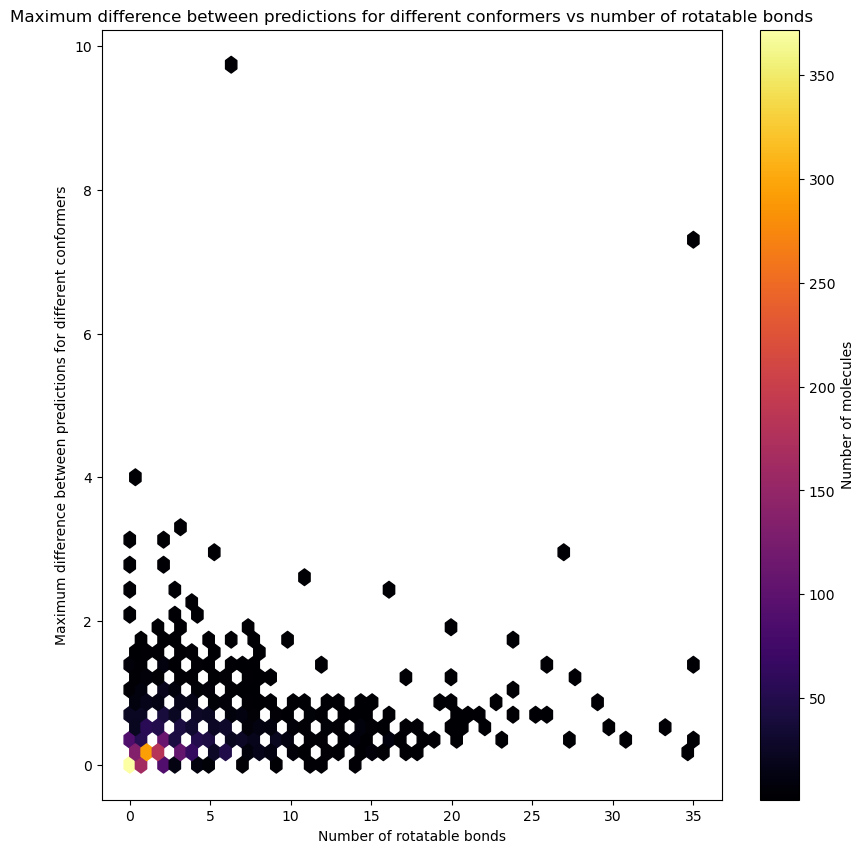

In [ ]:
#hexabin max diff vs n_rotatable_bonds
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10, 10))
hb = ax.hexbin(max_diffs['n_rotatable_bonds']['mean'], max_diffs['prediction']['max'] - max_diffs['prediction']['min'], gridsize=50, cmap='inferno',mincnt=1)
ax.set_xlabel('Number of rotatable bonds')
ax.set_ylabel('Maximum difference between predictions for different conformers')
ax.set_title('Maximum difference between predictions for different conformers vs number of rotatable bonds')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of molecules')
plt.show()

As shown in Experiments_error_analysis/002_errors_from_flexibility.ipynb, the number of rotatable bonds does not seem to be directly correlated to the error of prediction

At this moment, 2D outperforms for pretty much all molecules

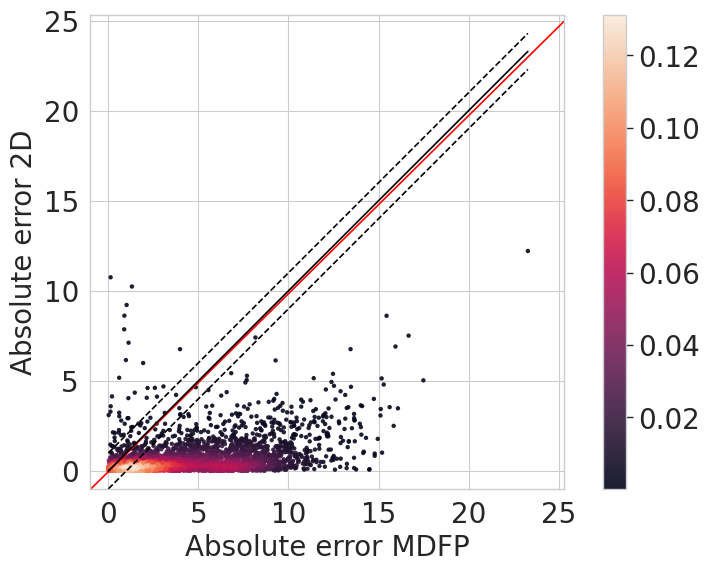

## Investigate where the gain is made when using multiple conformers

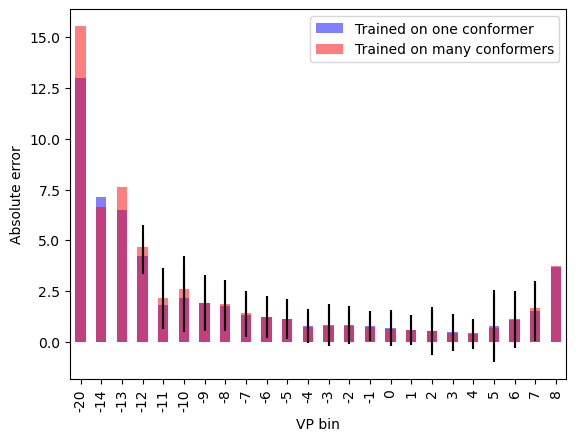

In [ ]:
df_pred_many_averaged = df_pred_many.copy()
#average over molregnos, keeping molregno as column
df_pred_many_averaged = df_pred_many_averaged.groupby('molregno', as_index=False).mean()
df_pred_many_averaged['abs_error_one'] = abs(df_pred_many_averaged['vp_log10pa'] - df_pred_many_averaged['pred_from_one'])
df_pred_many_averaged['abs_error_many'] = abs(df_pred_many_averaged['vp_log10pa'] - df_pred_many_averaged['pred_from_many'])
df_pred_many_averaged
#get bins of vp, each 1 
df_pred_many_averaged['vp_bin'] = np.floor(df_pred_many_averaged['vp_log10pa'])
df_pred_many_averaged['vp_bin'] = df_pred_many_averaged['vp_bin'].astype(int)
df_pred_many_averaged['vp_bin'].value_counts()
#plot average error for each bin
fig, ax = plt.subplots()

mean_one = df_pred_many_averaged['abs_error_one'].groupby(df_pred_many_averaged['vp_bin']).mean()
std_one = df_pred_many_averaged['abs_error_one'].groupby(df_pred_many_averaged['vp_bin']).std()
mean_many = df_pred_many_averaged['abs_error_many'].groupby(df_pred_many_averaged['vp_bin']).mean()
std_many = df_pred_many_averaged['abs_error_many'].groupby(df_pred_many_averaged['vp_bin']).std()
mean_one.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_one)
mean_many.plot.bar(ax=ax, color='red', alpha=0.5, yerr=std_many)

ax.set_xlabel('VP bin')
ax.set_ylabel('Absolute error')
ax.legend(['Trained on one conformer', 'Trained on many conformers'])
plt.show()



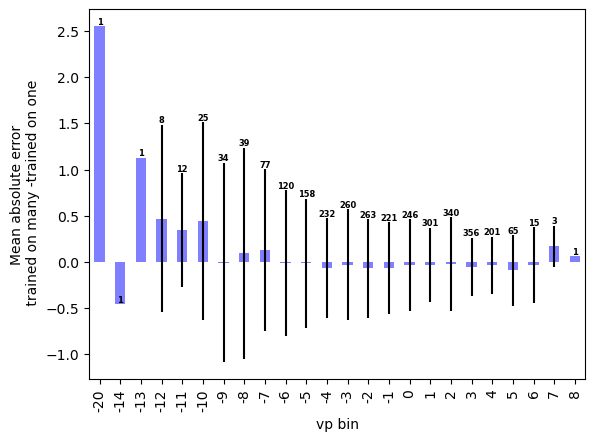

In [ ]:
import matplotlib.pyplot as plt

# assuming df_preds is your DataFrame
fig, ax = plt.subplots()
mean_diff = (df_pred_many_averaged['abs_error_many'] - df_pred_many_averaged['abs_error_one']).groupby(df_pred_many_averaged['vp_bin']).mean()
std_diff = (df_pred_many_averaged['abs_error_many'] - df_pred_many_averaged['abs_error_one']).groupby(df_pred_many_averaged['vp_bin']).std()
datapoints = (df_pred_many_averaged['abs_error_many'] - df_pred_many_averaged['abs_error_one']).groupby(df_pred_many_averaged['vp_bin']).count()
mean_diff.plot.bar(ax=ax, color='blue', alpha=0.5, yerr=std_diff)
ax.set_xlabel('vp bin')
ax.set_ylabel('Mean absolute error\n trained on many -trained on one')
for i, v in enumerate(datapoints):
    x = mean_diff.index[i]
    y = mean_diff[x] 
    if str(std_diff[x]) != "nan":
        y += std_diff[x]
    ax.text(i, y, str(v), color='black', fontweight='bold', ha='center', va='bottom',fontsize=6)
plt.show()